# β-TCVAE Model Testing Framework

In [1]:
from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader

seed = 42
set_deterministic_run(seed=seed)

## 1. Imports

In [2]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## 2. Configuration

In [3]:
# --- General Hyperparameters ---
model_name = 'vae_locatello'  # Name of the model architecture file (e.g., 'vae_burgess')
latent_dim = 10
learning_rate = 1e-4
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rec_dist = 'bernoulli'  # Reconstruction distribution (e.g., 'bernoulli', 'gaussian')


train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 5

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

In [4]:
# --- Loss Specific Hyperparameters ---
# Beta-TCVAE
loss_name = 'betatcvae'      # Type of loss ('betavae', 'annealedvae', 'betatcvae')
loss_kwargs = {
    'alpha': 1.0,    # Weight for mutual information term
    'beta': 6.0,     # Weight for total correlation term
    'gamma': 1.0,    # Weight for dimension-wise KL term
    'is_mss': True,  # Use minibatch stratified sampling
    'rec_dist': rec_dist,
               }

## 3. Load Datasets

In [5]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

# shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d_dataset, batch_size=batch_size, num_workers=num_workers_3dshapes, shuffle=True, pin_memory=True)
shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=seed,
                                                   pin_memory=True)

print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")


Loaded 3D Shapes dataset with 480000 samples.


In [6]:
# Load dSprites
Dsprites = get_dataset('dsprites')

dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

# dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, batch_size=batch_size, num_workers=num_workers_dsprites, shuffle=True, pin_memory=True)
dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,
                                                   pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 737280 samples.


## 4. Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    

    # Instantiate Model
    model = vae_models.select(name=model_name, img_size=img_size, latent_dim=latent_dim)

    if loss_name == 'betatcvae':
        loss_kwargs['n_data'] = n_data
    
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.__class__.__name__}")
    print(f"Loss: {loss_fn.__class__.__name__} (rec_dist={rec_dist}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## 5. Train and Visualize

## 5.1 - 3D Shapes

In [8]:
shapes3d_loss_kwargs = {
    'alpha': 1.0,    # Weight for mutual information term
    'beta': 6.0,     # Weight for total correlation term
    'gamma': 1.0,    # Weight for dimension-wise KL term
    'is_mss': True,  # Use minibatch stratified sampling
    'rec_dist': rec_dist,
               }

In [9]:
print("\n===== Training on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)

trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                                      loss_fn=loss_fn_3dshapes,
                                      lr_scheduler=None,
                                      optimizer=optimizer_3dshapes,
                                      device=device,
                                      train_step_unit=train_step_unit,
                                      )

trainer_3dshapes.train(shapes3d_dataloader, max_steps=num_train_steps)


===== Training on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'alpha': 1.0, 'beta': 6.0, 'gamma': 1.0, 'is_mss': True, 'rec_dist': 'bernoulli', 'n_data': 480000}
Optimizer: Adam
---------------------------



===== Visualizing 3D Shapes Results =====
Plotting random reconstructions...


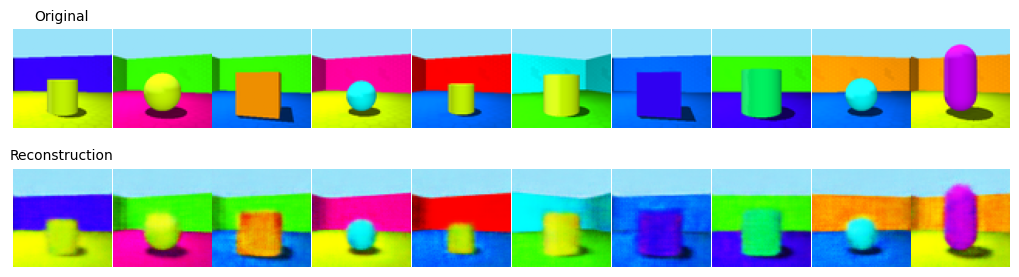

Plotting reconstructions from specific indices...


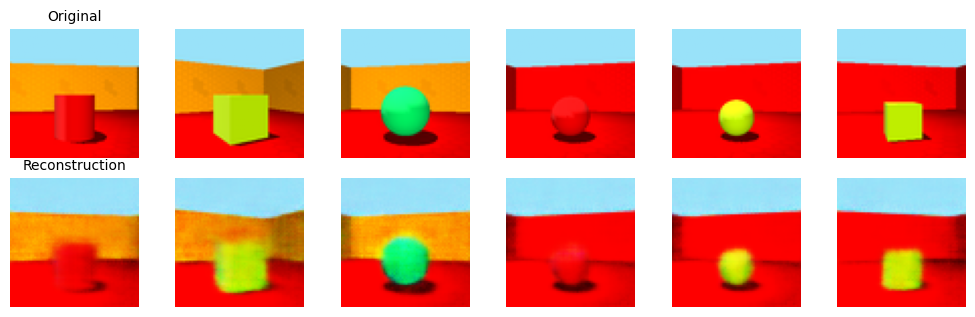

Plotting latent traversals...


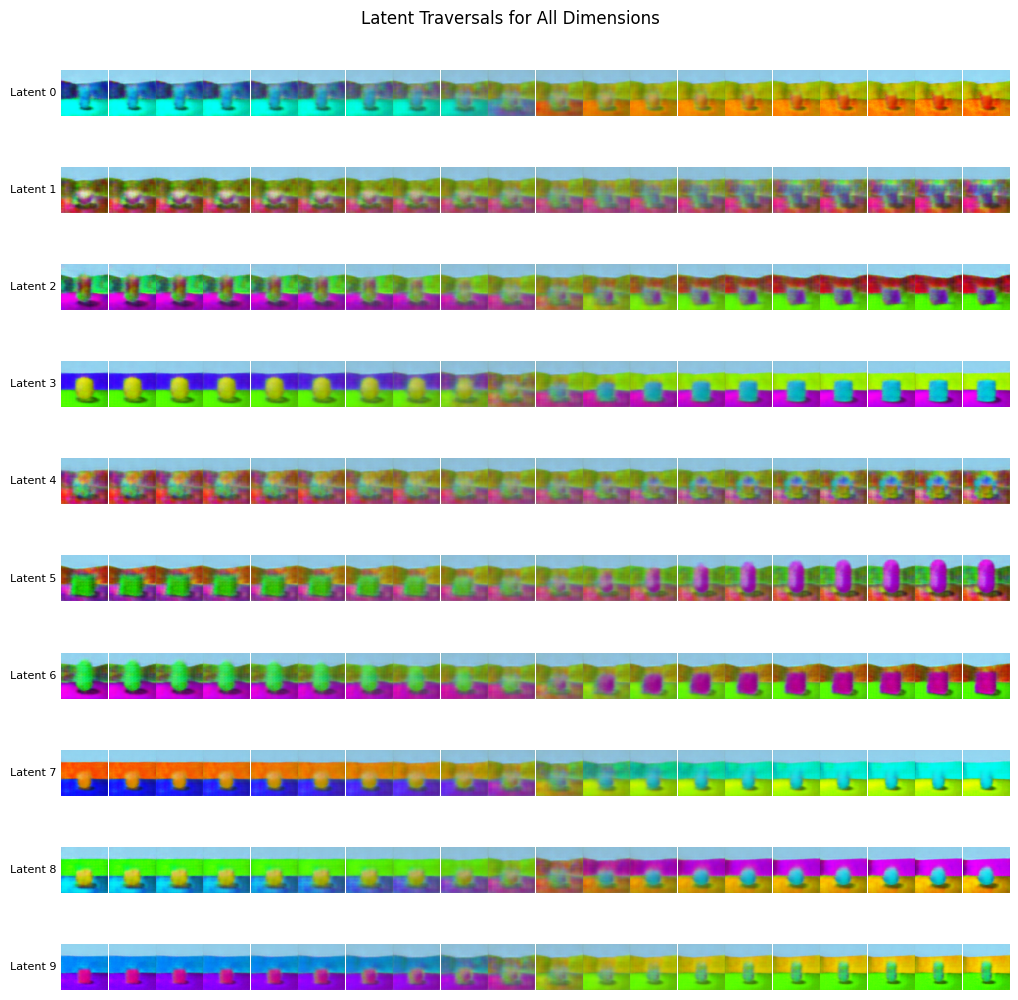

In [10]:
print("\n===== Visualizing 3D Shapes Results =====")
visualizer_3dshapes = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20)
plt.show()

### 5.1.1 Metric Evaluation (3D Shapes)

In [11]:
metrics_to_compute = [
    {'name': 'dci_d', 'args':{'num_train':5000, 'num_test':1000}}, # Added num_train and num_test
    {'name': 'mig', 'args':{}} # MIG uses default args (num_bins=20, num_workers=8, etc.)
]

In [12]:
metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

In [13]:
print("\n===== Computing Metrics for 3D Shapes =====")
metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes, 
                                                              data_loader=shapes3d_dataloader, 
                                                              device=device)
print("3D Shapes Metrics:", metrics_results_3dshapes)


===== Computing Metrics for 3D Shapes =====


Computing representations: 100%|██████████| 7500/7500 [00:21<00:00, 348.37it/s]


3D Shapes Metrics: {'dci_d': {'informativeness_train_errors': 0.08726666666666666, 'informativeness_test_errors': 0.29683333333333334, 'informativeness_train_scores': 0.9127333333333333, 'informativeness_test_scores': 0.7031666666666666, 'disentanglement': 0.27364514697128706, 'completeness': 0.22415147619650985}, 'mig': 0.10999612070370061}


## 5.2. Train and Visualize: dSprites

### Loss args

In [14]:
# Beta-TCVAE
loss_kwargs_betatc_vae_dsprites = {
    'alpha': 1.0,    # Weight for mutual information term
    'beta': 8.0,     # Higher beta for dSprites dataset
    'gamma': 1.0,    # Weight for dimension-wise KL term
    'is_mss': True,  # Use minibatch stratified sampling
    'rec_dist': rec_dist,
               }

In [15]:
print("\n===== Training on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, loss_kwargs_betatc_vae_dsprites)

trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                     loss_fn=loss_fn_dsprites,
                                     lr_scheduler=None,
                                     optimizer=optimizer_dsprites,
                                     device=device,
                                     train_step_unit=train_step_unit,
                                     )

trainer_dsprites.train(dsprites_dataloader, max_steps=num_train_steps)


===== Training on dSprites =====
--- Setup for DSprites --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'alpha': 1.0, 'beta': 8.0, 'gamma': 1.0, 'is_mss': True, 'rec_dist': 'bernoulli', 'n_data': 737280}
Optimizer: Adam
---------------------------



===== Visualizing dSprites Results =====
Plotting random reconstructions...


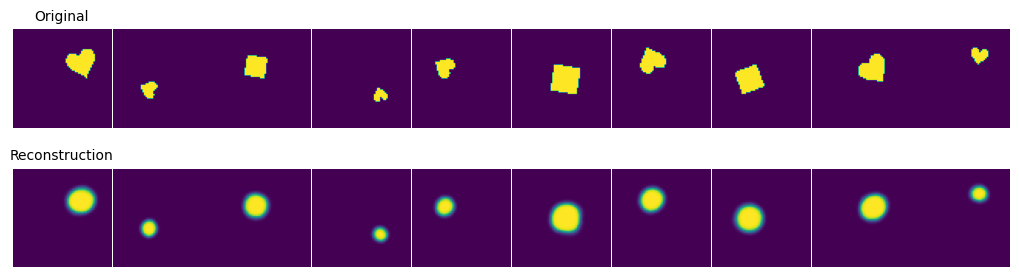

Plotting reconstructions from specific indices...


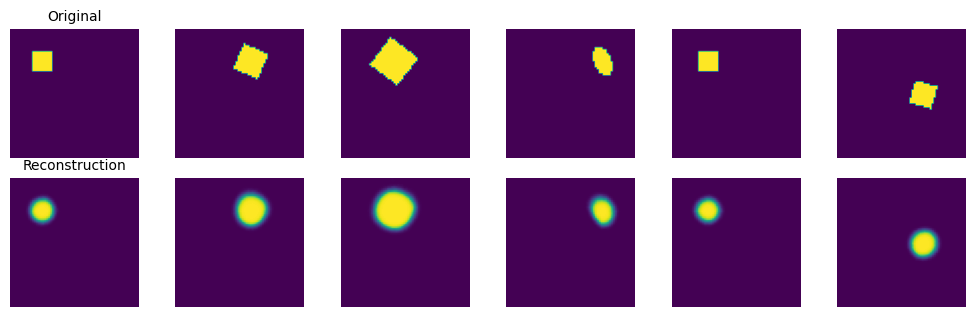

Plotting latent traversals...


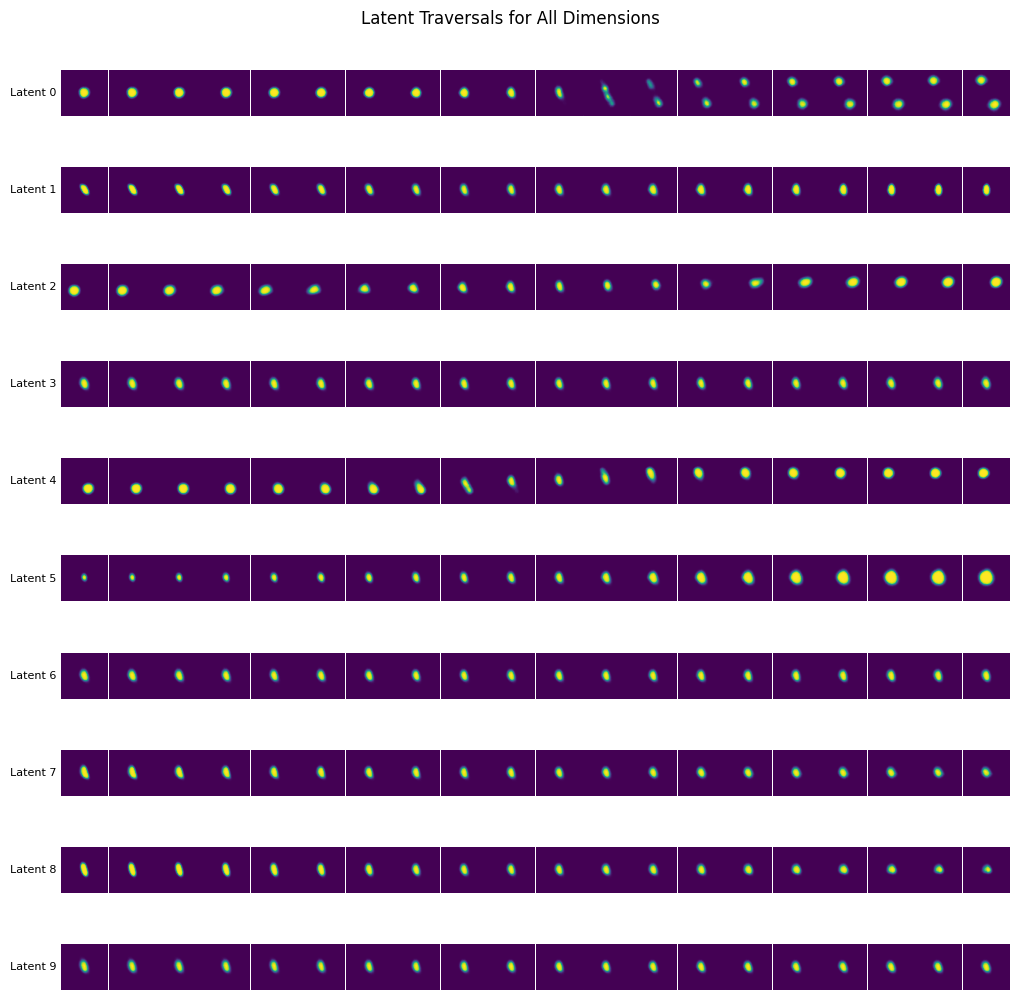

In [16]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.Visualizer(vae_model=model_dsprites, dataset=dsprites_dataset)

print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 100000, 200000, 300000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20)
plt.show()

### 5.2.1 Metric Evaluation (dSprites)

In [17]:
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

In [18]:
print("\n===== Computing Metrics for dSprites =====")
metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
                                                            data_loader=dsprites_dataloader, 
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)


===== Computing Metrics for dSprites =====


Computing representations: 100%|██████████| 11520/11520 [00:25<00:00, 458.07it/s]


dSprites Metrics: {'dci_d': {'informativeness_train_errors': 0.08603999999999998, 'informativeness_test_errors': 0.49559999999999993, 'informativeness_train_scores': 0.91396, 'informativeness_test_scores': 0.5044000000000001, 'disentanglement': 0.2836870749096053, 'completeness': 0.2915201108508031}, 'mig': 0.22288036541182019}


## 6. Understanding β-TCVAE

The β-TCVAE (Beta Total Correlation VAE) model decomposes the KL divergence term into three components:

1. **Mutual Information** (scaled by `alpha`): Measures the amount of information between latent variables and data
2. **Total Correlation** (scaled by `beta`): Measures the dependencies between latent dimensions 
3. **Dimension-wise KL** (scaled by `gamma`): Regularizes each latent dimension toward the prior

The decomposition allows more targeted regularization of specific properties of the latent space, particularly focusing on the total correlation to encourage disentanglement.